## Imports

In [ ]:
import random
from dataclasses import dataclass, field

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

random.seed(42)

## Data generation

In [ ]:
@dataclass
class DyckKMNGenerator:
    """
    A generator for creating sequences of the Dyck-(K,M,N) language.

    Attributes:
        num_bracket_types (int): The number of different types of brackets.
        max_stack_depth (int): The maximum depth of the stack (M).
        max_seq_length (int): The maximum length of the sequence (N).

    Methods:
        generate_sample: Generates a single sample sequence of the Dyck-(K,M,N) language.
    """
    num_bracket_types: int
    max_stack_depth: int
    max_seq_length: int

    def generate_sample(self) -> list[str]:
        """
        Generates a single balanced sequence of the Dyck-(K,M,N) language.

        The method ensures that the generated sequence is a valid Dyck sequence
        by matching each opening bracket with the correct closing bracket,
        adhering to the maximum stack depth and sequence length constraints.

        Returns:
            list: A list of strings representing a valid Dyck sequence.
        """
        stack = []
        string = []
        random_max_length = random.randint(5, self.max_seq_length)
        random_max_stack_depth = random.randint(1, self.max_stack_depth)
        while len(string) < random_max_length:
            if len(stack) < random_max_stack_depth and random.choice([True, False]):
                bracket_type = chr(97 + random.randint(0, self.num_bracket_types - 1))
                string.append('(' + bracket_type)
                stack.append(bracket_type)
            elif stack:
                string.append(')' + stack.pop())
            else:
                bracket_type = chr(97 + random.randint(0, self.num_bracket_types - 1))
                string.append('(' + bracket_type)
                stack.append(bracket_type)
            if len(string) == random_max_length and stack:
                while stack:
                    string.append(')' + stack.pop())
                break
        return string

num_bracket_types = 2
max_stack_depth = 5
max_seq_length = 75

generator = DyckKMNGenerator(num_bracket_types, max_stack_depth, max_seq_length)
for _ in range(5):  # Generate 5 samples
    sample = generator.generate_sample()
    print(' '.join(sample))

(a )a (a )a (a )a (a )a (a )a (a )a (a )a (a )a (b )b (a )a
(a (b (a )a )b (b )b )a (b (b (b )b )b (a (a )a )a (a (b )b )a )b (a )a (a )a (a (a )a )a (a )a (a (b )b )a (a )a (b )b (a )a (a )a (b )b (a )a (a (a (b )b (b )b )a )a (a (b )b )a
(a )a (b (a )a (a )a (a )a )b (a )a (a (a (a )a )a (a (b )b )a )a
(b (a )a )b (b )b (a (a )a (b )b (a )a (a )a (a )a (a )a (b )b (a )a )a (a (b )b (b )b )a (a (b )b )a (b )b (a (b )b )a (a (a )a )a (b (b )b )b (a )a (a (a )a (a )a )a (b (b )b (a )a )b (b )b (b )b (a (b )b (a )a (b )b (a )a )a
(a (a (a (b (a )a (a )a )b )a )a (b (b )b (b )b )b (a )a (a (b (b (a )a )b )b (b )b (b (a )a (a (b )b )a (b (b )b )b )b (a )a )a (a )a (b (b )b (a (a (b )b (b )b (a )a )a )a (b (a (b )b )a (a (a )a )a )b )b )a


In [ ]:
def is_valid_sequence(sequence: list[str]) -> bool:
    stack = []
    for char in sequence:
        if '(' in char:
            stack.append(char.strip('('))
        elif ')' in char:
            if not stack or stack[-1] != char.strip(')'):
                return False
            stack.pop()
    return not stack

In [ ]:
@dataclass
class BPVocab:
    corpus: list[tuple[str]]
    EOS_TOKEN: str = "#"
    tokens: list[str] = field(init=False)
    encoder: dict[str, int] = field(init=False)
    decoder: dict[int, str] = field(init=False)

    def __post_init__(self):
        tokens: set[str] = {char for seq in self.corpus for char in seq}

        self.tokens = sorted(list(tokens)) + [self.EOS_TOKEN]
        self.encoder = {char: idx for idx, char in enumerate(self.tokens)}
        self.decoder = {idx: char for char, idx in self.encoder.items()}

    def encode(self, char: str) -> int:
        return self.encoder[char]

    def decode(self, idx: int) -> str:
        return self.decoder[idx]

    @property
    def num_of_tokens(self):
        return len(self.tokens)

def make_corpus(num_bracket_types: int) -> list[tuple[str]]:
    corpus = []
    for i in range(num_bracket_types):
        open = "(" + chr(97 + i)
        close = ")" + chr(97 + i)
        corpus.append((open, close))
    return corpus

In [ ]:
class InfiniteBPDataset(Dataset):
    def __init__(self, vocab: BPVocab, generator: DyckKMNGenerator):
        self.vocab = vocab
        self.generator = generator

    def __len__(self):
        return 1

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        def encode(seq):
            seq = seq + [self.vocab.EOS_TOKEN]
            x, y = seq[:-1], seq[1:]
            x_encoded = torch.tensor([self.vocab.encode(char) for char in x])
            y_encoded = torch.tensor([self.vocab.encode(char) for char in y])
            return x_encoded, y_encoded

        return encode(self.generator.generate_sample())

In [ ]:
@dataclass
class PushdownAutomata:
    history: list[str] = field(default_factory=list)
    stack: list[str] = field(default_factory=list)

    def transition(self, char):
        if "(" in char:
            self.stack.append(char)
        else:
            self.stack.pop()
        self.history.append(len(self.stack))

## Visualization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def viz(hidden_states, states, depth, hidden_size, path, dim3 = False):

  last_hidden_states = hidden_states[-3000:]
  last_states               = states[-3000:]
  states_np = [ h_tensor.cpu().numpy() for h_tensor in last_hidden_states]
  states_np = np.asarray(states_np).reshape(-1, hidden_size)

  pca = PCA(n_components=3 if dim3 else 2)
  X_embedded = pca.fit_transform(states_np)

  if dim3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], last_states, c=last_states)

  else:
    fig, ax = plt.subplots()
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=last_states)

  legend_elements, legend_labels = scatter.legend_elements()
  legend1 = ax.legend(handles=legend_elements, labels=[i for i in range(depth + 1)], title="STATES", loc="best")


  ax.add_artist(legend1)
  #plt.savefig(path)
  plt.show()
  plt.close()

In [ ]:
import os
def make_dir(dir_path):
    os.makedirs(dir_path, exist_ok=True)

## Language models

In [ ]:
class RNNCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(RNNCell, self).__init__()

        self.Wxh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.xavier_uniform_(self.Wxh)
        nn.init.xavier_uniform_(self.Whh)

        nn.init.zeros_(self.bh)

    def forward(self, x: torch.Tensor, h_state: torch.Tensor) -> torch.Tensor:
        h_input = x @ self.Wxh
        h_hidden = h_state @ self.Whh
        preact = h_input + h_hidden + self.bh
        h_next = torch.tanh(preact)
        return h_next

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(GRUCell, self).__init__()

        # Weights and biases for the update gate
        self.Wxz = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whz = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bz = nn.Parameter(torch.Tensor(hidden_size))

        # Weights and biases for the reset gate
        self.Wxr = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whr = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.br = nn.Parameter(torch.Tensor(hidden_size))

        # Weights and biases for the candidate hidden state
        self.Wxh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        for weight in [self.Wxz, self.Whz, self.Wxr, self.Whr, self.Wxh, self.Whh]:
            nn.init.xavier_uniform_(weight)

        for bias in [self.bz, self.br, self.bh]:
            nn.init.zeros_(bias)

    def forward(self, x: torch.Tensor, h_state: torch.Tensor) -> torch.Tensor:
        # Update gate
        z = F.sigmoid(x @ self.Wxz + h_state @ self.Whz + self.bz)

        # Reset gate
        r = F.sigmoid(x @ self.Wxr + h_state @ self.Whr + self.br)

        # Candidate hidden state
        h_tilde = torch.tanh(x @ self.Wxh + r * (h_state @ self.Whh) + self.bh)

        # Next hidden state
        h_next = (1 - z) * h_state + z * h_tilde

        return h_next

In [ ]:
class IntraAttention(nn.Module):
    def __init__(self, hidden_size):
        super(IntraAttention, self).__init__()
        self.W_omega = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.u_omega = nn.Parameter(torch.Tensor(hidden_size))
        self.b_omega = nn.Parameter(torch.Tensor(hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.W_omega, mean=0.0, std=0.1)
        nn.init.normal_(self.u_omega, mean=0.0, std=0.1)
        nn.init.zeros_(self.b_omega)

    def forward(self, hidden_states):
        u_t = torch.tanh(torch.matmul(hidden_states, self.W_omega) + self.b_omega)
        att = torch.matmul(u_t, self.u_omega)
        att_weights = F.softmax(att, dim=1).unsqueeze(-1)
        attended_states = hidden_states * att_weights

        return torch.sum(attended_states, dim=1), att_weights

In [ ]:
class DropoutLayer(nn.Module):
    def __init__(self, p: float = 0.5):
        super(DropoutLayer, self).__init__()
        assert p > 0.0 and p < 1.0
        self.p = p
        self.mask = None

    def forward(self, x):
        if self.training:
            self.mask = (torch.rand(x.shape, device=x.device) > self.p).float()
            return x * self.mask / (1.0 - self.p)
        return x

In [ ]:
@dataclass(frozen=True)
class ModelConfig:
    hidden_size: int
    num_of_layers: int
    cell: str
    with_attention: bool
    apply_dropout: bool

    @property
    def model_id(self):
        attention_part = "_ATT" if self.with_attention else ""
        dropout_part = "_DROPOUT" if self.apply_dropout else ""
        return f"{self.cell.upper()}_H{self.hidden_size}_L{self.num_of_layers}{attention_part}{dropout_part}"

config = ModelConfig(hidden_size=32, num_of_layers=1, cell='gru', with_attention=True, apply_dropout=True)
config.model_id

'GRU_H32_L1_ATT_DROPOUT'

In [ ]:
class CompactCharRNN(nn.Module):
    def __init__(self, config: ModelConfig, vocab: BPVocab, psa: PushdownAutomata):
        super(CompactCharRNN, self).__init__()
        self.config = config

        self.vocab = vocab
        self.attention = IntraAttention(self.config.hidden_size) if self.config.with_attention else None
        self.dropout = DropoutLayer(0.3) if self.config.apply_dropout else None
        p_dim = self.config.hidden_size * 2 if self.config.with_attention else self.config.hidden_size

        self.Why = nn.Parameter(torch.Tensor(p_dim, self.vocab.num_of_tokens))
        self.by = nn.Parameter(torch.Tensor(self.vocab.num_of_tokens))

        self.reset_parameters()
        self.init_rnns()
        self.psa = psa
        self.accumulated_hidden_states = list()

    def init_rnns(self):
        hidden_size = self.config.hidden_size
        num_of_tokens = self.vocab.num_of_tokens
        num_of_layers = self.config.num_of_layers
        if self.config.cell == "gru":
            self.rnn_cells = nn.ModuleList([
                GRUCell(num_of_tokens if i==0 else hidden_size, hidden_size)
                for i in range(num_of_layers)
            ])
        elif self.config.cell == "rnn":
            self.rnn_cells = nn.ModuleList([
                RNNCell(num_of_tokens if i==0 else hidden_size, hidden_size)
                for i in range(num_of_layers)
            ])
        else:
            raise ValueError(f"{self.config.cell} not supported.")

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.Why)
        nn.init.zeros_(self.by)

    def one_hot_encode(self, indices: torch.Tensor) -> torch.Tensor:
        return F.one_hot(indices, num_classes=self.vocab.num_of_tokens).float()

    def forward(self, x: torch.Tensor, h_states: list[torch.Tensor]):
        outputs = []
        hidden_states = []
        batch_size, seq_length = x.shape

        for t in range(seq_length):
            emb = self.one_hot_encode(x[:, t])
            for i, rnn_cell in enumerate(self.rnn_cells):
                emb = rnn_cell(emb, h_states[i])
                h_states[i] = emb

            if self.training:
                self.psa.transition(self.vocab.decode(x[:,t].cpu().item())) # PSA
                self.accumulated_hidden_states.append(emb.detach().clone())
            hidden_states.append(emb.unsqueeze(1))

            if self.attention:
                # Accumulate hidden states up to current time step
                acc_states = torch.cat(hidden_states, dim=1)
                context, _ = self.attention(acc_states)

                # Combine RNN output with attention context
                output = torch.cat([emb, context], dim=-1)
            else:
                output = emb
            if self.dropout:
                output = self.dropout(output)



            output = output @ self.Why + self.by
            outputs.append(output)

        return torch.stack(outputs, dim=1), h_states

## Experiment

In [ ]:
def sample_from_model(model, max_length, temperature=1.0, device='cuda'):
    """
    Generate a sequence using the trained model.

    Parameters:
    - model: Trained PyTorch model for sequence generation.
    - max_length: Maximum length of the generated sequence.
    - temperature: Controls the randomness of predictions.
    - device: The device to run the model on ('cuda' or 'cpu').

    Returns:
    - A string representing a generated sequence.
    """

    model.eval()  # Set the model to evaluation mode
    num_of_layers = model.config.num_of_layers
    hidden_size = model.config.hidden_size
    integer_tokens = list(model.vocab.encoder.values())
    # Initialize the sequence
    sequence = ["(a"]
    input_sequence = [model.vocab.encode('(a')]  # Start with an opening parenthesis

    with torch.no_grad():
        hidden_states = [torch.zeros(1, hidden_size).to(device) for _ in range(num_of_layers)]

        while len(sequence) < max_length:
            # Convert current input sequence to a tensor
            input_tensor = torch.tensor([input_sequence[-1]]).unsqueeze(0).to(device)

            # Get the model's prediction for the next character
            output, hidden_states = model(input_tensor, hidden_states)
            probabilities = torch.nn.functional.softmax(output / temperature, dim=-1).squeeze().cpu().numpy()

            # Sample the next token (character)
            next_token = np.random.choice(integer_tokens, p=probabilities)

            # Decode the next token and add it to the sequence
            next_char = model.vocab.decode(next_token)
            sequence.append(next_char)
            input_sequence.append(next_token)

            # If EOS token is generated, stop sampling
            if next_char == model.vocab.EOS_TOKEN:
                break
    return sequence

In [ ]:
def train_model(model, data_loader, optimizer, criterion, num_epochs, path, max_stack_depth, device='cuda'):
    """
    Train the model.

    Parameters:
    - model: The PyTorch model to be trained.
    - data_loader: DataLoader for the training dataset.
    - optimizer: Optimizer for the training.
    - criterion: Loss function.
    - num_epochs: Number of epochs to train.
    - device: The device to run the model on ('cuda' or 'cpu').
    """

    model.to(device)
    model.train()
    hidden_size = model.config.hidden_size
    num_of_layers = model.config.num_of_layers
    total_loss = 0
    cnt = 0
    for epoch in tqdm(range(num_epochs)):
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Initialize hidden state for each batch
            hidden_states = [torch.zeros(inputs.size(0), hidden_size).to(device) for _ in range(num_of_layers)]
            # print(hidden_state.shape)
            # Forward pass
            outputs, _ = model(inputs, hidden_states)

            loss = criterion(outputs.view(-1, model.vocab.num_of_tokens), targets.view(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 500 == 0:
            cnt += 1
            average_loss = total_loss / (epoch+1)
            model.accumulated_hidden_states = model.accumulated_hidden_states[-1500:]
            model.psa.history = model.psa.history[-1500:]
            viz(model.accumulated_hidden_states, model.psa.history, max_stack_depth, hidden_size, f"{path}{cnt}.png", True)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    k: int
    m: int
    n: int

    @property
    def dataset_id(self):
        return f"K{self.k}_M{self.m}_N{self.n}"

In [ ]:
def evaluate(model):
    ss = []
    N = 1000
    for _ in range(N):
        ss.append(sample_from_model(model, max_length=500, device="cpu"))
    return sum(is_valid_sequence(s) for s in ss) / N


In [ ]:
def make_experiment(dataset_config: DatasetConfig, model_config: ModelConfig, lr = 0.0009, num_epochs = 20000):
    generator = DyckKMNGenerator(dataset_config.k, dataset_config.m, dataset_config.n)
    corpus = make_corpus(generator.num_bracket_types)
    vocab = BPVocab(corpus)
    dataset = InfiniteBPDataset(vocab=vocab, generator=generator)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model = CompactCharRNN(config=model_config, vocab=vocab, psa = PushdownAutomata())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    experiment_id = f"{model_config.model_id}/{dataset_config.dataset_id}"
    model_id = f"{model_config.model_id}_{dataset_config.dataset_id}"
    plot_dir = f"plots/{experiment_id}/"

    make_dir(plot_dir)
    train_model(model, data_loader, optimizer, criterion, num_epochs, plot_dir, max_stack_depth=generator.max_stack_depth, device="cpu")
    acc = evaluate(model)
    print(f"Accuracy: {acc:.4f}")
    #torch.save(model.state_dict(), f"models/{model_id}_ACC_{acc:.4f}.pth")



  0%|          | 0/5000 [00:00<?, ?it/s]

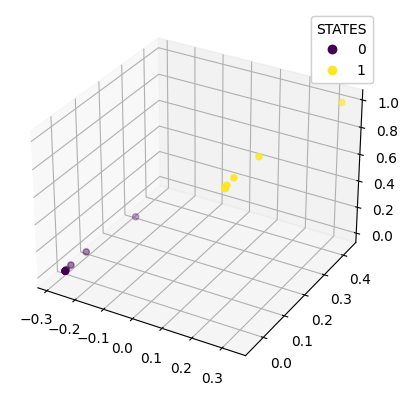

  0%|          | 4/5000 [00:00<07:05, 11.74it/s]

Epoch [1/5000], Loss: 0.9258


 10%|▉         | 498/5000 [00:24<03:47, 19.83it/s]

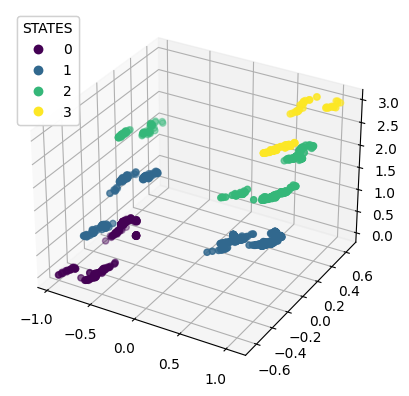

 10%|█         | 503/5000 [00:25<06:24, 11.69it/s]

Epoch [501/5000], Loss: 0.7121


 20%|██        | 1000/5000 [00:49<03:06, 21.42it/s]

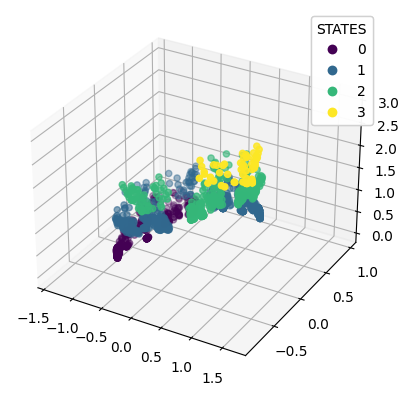

 20%|██        | 1003/5000 [00:50<05:46, 11.52it/s]

Epoch [1001/5000], Loss: 0.6616


 30%|██▉       | 1499/5000 [01:14<02:29, 23.49it/s]

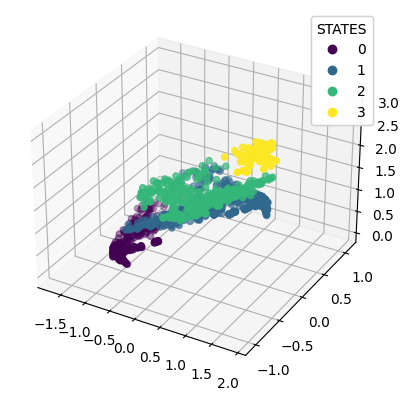

 30%|███       | 1505/5000 [01:14<03:59, 14.57it/s]

Epoch [1501/5000], Loss: 0.6234


 40%|████      | 2000/5000 [01:38<01:49, 27.34it/s]

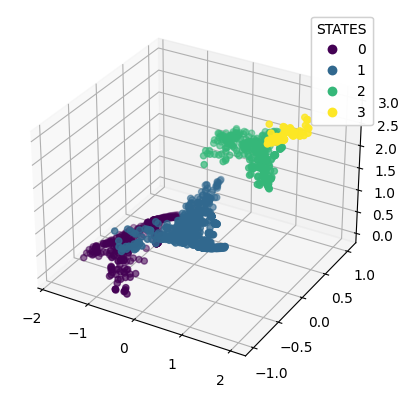

 40%|████      | 2003/5000 [01:39<03:35, 13.88it/s]

Epoch [2001/5000], Loss: 0.5944


 50%|████▉     | 2498/5000 [02:03<01:58, 21.19it/s]

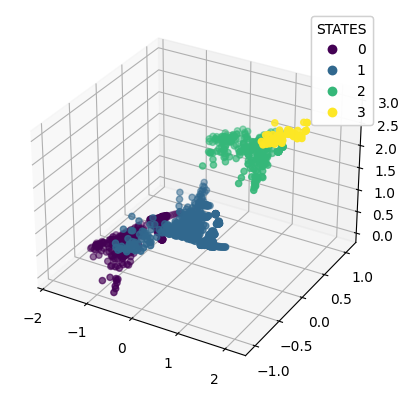

 50%|█████     | 2503/5000 [02:04<03:23, 12.27it/s]

Epoch [2501/5000], Loss: 0.5767


 60%|█████▉    | 2999/5000 [02:29<01:21, 24.41it/s]

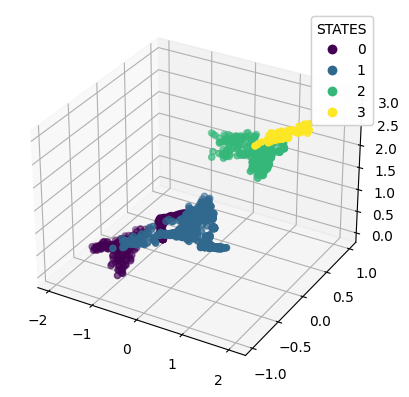

 60%|██████    | 3004/5000 [02:29<02:25, 13.68it/s]

Epoch [3001/5000], Loss: 0.5642


 70%|██████▉   | 3498/5000 [02:53<01:08, 21.80it/s]

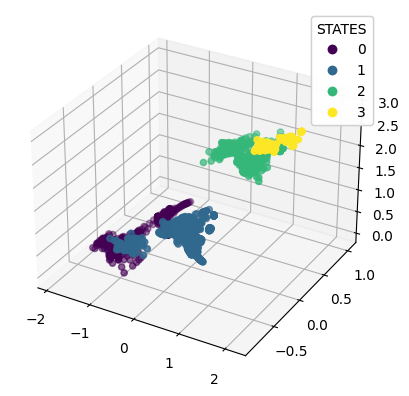

 70%|███████   | 3504/5000 [02:54<01:39, 15.01it/s]

Epoch [3501/5000], Loss: 0.5540


 80%|████████  | 4000/5000 [03:19<00:47, 21.15it/s]

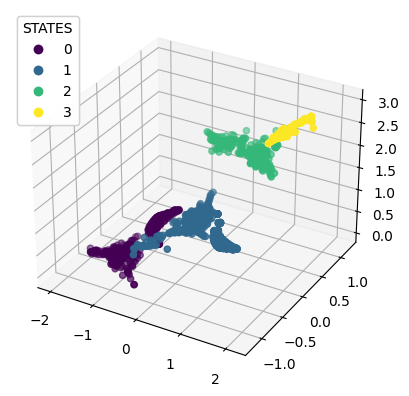

 80%|████████  | 4006/5000 [03:20<01:06, 15.05it/s]

Epoch [4001/5000], Loss: 0.5463


 90%|████████▉ | 4499/5000 [03:44<00:19, 25.45it/s]

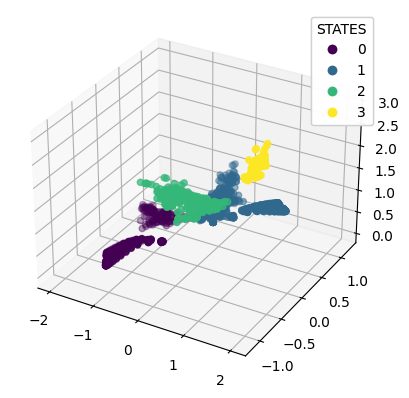

 90%|█████████ | 4505/5000 [03:45<00:32, 15.25it/s]

Epoch [4501/5000], Loss: 0.5378


100%|██████████| 5000/5000 [04:10<00:00, 19.98it/s]


Accuracy: 0.8430


In [ ]:
# adjust configs here for different experiments
dataset = DatasetConfig(1, 3, 50)
rnn = ModelConfig(
    hidden_size = 16,
    num_of_layers = 1,
    cell = "gru",
    with_attention = True,
    apply_dropout = True
)

make_experiment(dataset, rnn, num_epochs=5000)